## Pegasus Fine Tuning 

### Setup

In [2]:
import torch 
from torch import cuda
device = torch.device("cuda") #if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F

In [3]:
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# WandB – Import the wandb library
import wandb
import time
from rouge_score import rouge_scorer
import shap
import sentencepiece

In [4]:
save_directory = '/home/aiffelsummabot/Pegasus/finetuned_model'

predictions_filepath = '/home/aiffelsummabot/Pegasus/predictions/pegasus_predictions.csv'

wandb_project_name = "pegasus"

### Data

In [4]:
filepath = 'train_data_final.csv'

train_df = pd.read_csv(filepath, index_col=0)
train_df.head()

,Original_Filename,Full_Text,FT_Len,Summary
0,15783_819108_2,chief executive officer’s statement the berong...,500.0,the berong nickel mine has been in operation f...
1,15782_819091_2,chief executive officer’s statement the compan...,500.0,berong nickel corporation is setting new stand...
2,15787_819176_2,page 6 toledo mining corporation plc annual re...,500.0,toledo mining corporation plc reported a pre-t...
3,15819_820208_2,review 2005 chief executive’s statement tomkin...,500.0,a key component of this is new product develop...
4,15842_821001_2,7 plc annual report and financial statements 2...,500.0,topps has seen its position as the uk’s number...


In [5]:
train_df.reset_index(drop=True, inplace=True)
train_df.head()

,Original_Filename,Full_Text,FT_Len,Summary
0,15783_819108_2,chief executive officer’s statement the berong...,500.0,the berong nickel mine has been in operation f...
1,15782_819091_2,chief executive officer’s statement the compan...,500.0,berong nickel corporation is setting new stand...
2,15787_819176_2,page 6 toledo mining corporation plc annual re...,500.0,toledo mining corporation plc reported a pre-t...
3,15819_820208_2,review 2005 chief executive’s statement tomkin...,500.0,a key component of this is new product develop...
4,15842_821001_2,7 plc annual report and financial statements 2...,500.0,topps has seen its position as the uk’s number...


#### 짧은 데이터 제거해주기 

<AxesSubplot:>

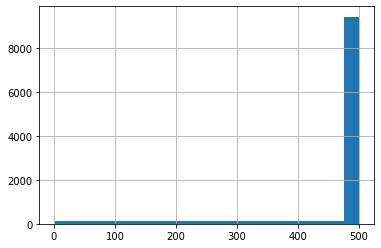

In [8]:
train_df['FT_Len'].hist(bins=20)

In [9]:
train_df['FT_Len'].describe()

count    11954.000000
mean       444.643299
std        123.898723
min          1.000000
25%        500.000000
50%        500.000000
75%        500.000000
max        500.000000
Name: FT_Len, dtype: float64

In [10]:
train_df.loc[train_df['FT_Len'] < 200]

,Original_Filename,Full_Text,FT_Len,Summary
2720,15819_820208_2,of our cost of capital in the years ahead . ne...,53.0,nicol's businesses are focused on creating sha...
2749,16184_838031_2,"principle , to the economic uncertainties that...",163.0,to the economic uncertainties that our custome...
2771,16367_846240_2,. this order was completed in february 2012 an...,184.0,"in march 2012, we announced that ge aviation p..."
2790,16497_853744_2,the continuing development of the geneice plat...,109.0,dr satu vainikka chief executive officer val20...
2810,16717_862599_2,to fill our new capacity with a diverse mix of...,130.0,victrex will continue to provide a clear point...
...,...,...,...,...
11920,7194_368643_2,specific market sectors to take full advantage...,93.0,tony brewer group chief executive uk deliverie...
11923,7309_378031_2,appraisal activities and approximately dollar ...,107.0,", we invest approximately dollar 55 million to..."
11936,150_6208_2,of a target in half the time taken previously ...,173.0,jonathan milner ceo 8 september 2008. since th...
11939,169_12459_2,of server failure in the evening or at weekend...,67.0,acal it solutions offered expert knowledge to ...


In [6]:
train_df3 = train_df.loc[train_df['FT_Len'] >= 200].copy()
train_df3.reset_index(drop=True, inplace=True)
train_df3.describe()

,FT_Len
count,10897.000000
mean,478.069193
std,62.372498
min,200.000000
25%,500.000000
50%,500.000000
75%,500.000000
max,500.000000


#### Torch 데이터셋 만들기

In [12]:
# Creating a custom dataset for reading the dataframe and loading it into the dataloader to pass it to the neural network at a later stage for finetuning the model and to prepare it for predictions

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.text = self.data.Summary
        self.ctext = self.data.Full_Text

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        ctext = str(self.ctext[index])
        ctext = ' '.join(ctext.split())

        text = str(self.text[index])
        text = ' '.join(text.split())

        # input
        source = self.tokenizer.batch_encode_plus([ctext], max_length= self.source_len, 
                                                  pad_to_max_length=True,
                                                  return_tensors='pt',
                                                  truncation=True)
        
        # label
        target = self.tokenizer.batch_encode_plus([text], max_length= self.summ_len, 
                                                  pad_to_max_length=True,
                                                  return_tensors='pt',
                                                  truncation=True)

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

### 훈련

In [13]:
def train(epoch, tokenizer, model, loader, optimizer): # device
    model.train()
    for _,data in enumerate(loader, 0):
        # Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu
        # => You need to add your data to the same device as your model.
        y = data['target_ids'].to(device, dtype = torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)
        
        # Changed this code from lm_labels to labels; lm_labels is deprecated - https://github.com/priya-dwivedi/Deep-Learning/issues/137
        # outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, lm_labels=lm_labels)
        outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
        loss = outputs[0]
        
       # if _%10 == 0:
            # print(torch.cat(loss.item(), 0))
            #torch.cat(loss.item(), 0)
            # wandb.log({"Training Loss": loss.item()})

        #if _%500==0:
            #print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # xm.optimizer_step(optimizer)
        # xm.mark_step()
        return model

In [14]:
def validate(epoch, tokenizer, model, loader): #device
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            # Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu
            # => You need to add your data to the same device as your model.
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)
            # DataParallel 일때 한 행동 1 : model 을 module 로 감싸주었음.
            generated_ids = model.module.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

In [17]:
model_name = "human-centered-summarization/financial-summarization-pegasus"
# Further this model is sent to device (GPU/TPU) for using the hardware.
model = PegasusForConditionalGeneration.from_pretrained(model_name)
model= torch.nn.DataParallel(model)
model.to(device)
# DataParallel 일때 한 행동 1 : 주석해제했음

DataParallel(
  (module): PegasusForConditionalGeneration(
    (model): PegasusModel(
      (shared): Embedding(96103, 1024, padding_idx=0)
      (encoder): PegasusEncoder(
        (embed_tokens): Embedding(96103, 1024, padding_idx=0)
        (embed_positions): PegasusSinusoidalPositionalEmbedding(512, 1024)
        (layers): ModuleList(
          (0): PegasusEncoderLayer(
            (self_attn): PegasusAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          

In [18]:
# import torch
# torch.cuda

<module 'torch.cuda' from '/home/aiffelsummabot/anaconda3/envs/summabot/lib/python3.7/site-packages/torch/cuda/__init__.py'>

In [19]:
# import os

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [20]:
# USE_CUDA = torch.cuda.is_available()
# print(USE_CUDA)
# print(torch.cuda.device_count())
# print(device)
# print(torch.cuda.current_device())
# #if torch.cuda.device_count() > 1:


True
2
cuda
0


In [24]:
def main():
    # WandB – Initialize a new run
    wandb.init(project=wandb_project_name)

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
    config = wandb.config          # Initialize config
    config.TRAIN_BATCH_SIZE = 1    # input batch size for training (default: 64)
    config.VALID_BATCH_SIZE = 1    # input batch size for testing (default: 1000)
    config.TRAIN_EPOCHS = 5        # TO BE UPDATED. number of epochs to train (default: 10)
    config.VAL_EPOCHS = 1 
    config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    config.SEED = 42               # random seed (default: 42)
    config.MAX_LEN = 512
    config.SUMMARY_LEN = 150 

    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(config.SEED) # pytorch random seed
    np.random.seed(config.SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True 

    model_name = "human-centered-summarization/financial-summarization-pegasus"
    tokenizer = PegasusTokenizer.from_pretrained(model_name) 

    # Importing and Pre-Processing the domain data
    # Selecting the needed columns only. 
    # Adding the summarzie text in front of the text. 
    df = train_df3
    df = df[['Full_Text','Summary']]
    print(df.head())
    
    # Creation of Dataset and Dataloader
    # Defining the train size. So 80% of the data will be used for training and the rest will be used for validation. 
    train_size = 0.8
    split = int(train_size * df.shape[0])
    #train_dataset=df.sample(frac=train_size,random_state = config.SEED)
    train_dataset = df.iloc[:split]
    val_dataset = df.iloc[split:]
    val_dataset=df.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    print("FULL Dataset: {}".format(df.shape))
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("VALIDATION Dataset: {}".format(val_dataset.shape))


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)

    # model placeholder

    # Defining the optimizer that will be used to tune the weights of the network in the training session. 
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
    #    train(epoch, tokenizer, model, device, training_loader, optimizer)
        fine_tuned_model = train(epoch, tokenizer, model, training_loader, optimizer) #device


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, val_loader) # device
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        final_df.to_csv(predictions_filepath)
        print('Output Files generated for review')
    
    wandb.finish()
    return fine_tuned_model

if __name__ == '__main__':
    fine_tuned_model = main()
    fine_tuned_model.module.save_pretrained(save_directory=save_directory)

wandb: Currently logged in as: summabot (use `wandb login --relogin` to force relogin)


                                           Full_Text  \
0  chief executive officer’s statement the berong...   
1  chief executive officer’s statement the compan...   
2  page 6 toledo mining corporation plc annual re...   
3  review 2005 chief executive’s statement tomkin...   
4  7 plc annual report and financial statements 2...   

                                             Summary  
0  the berong nickel mine has been in operation f...  
1  berong nickel corporation is setting new stand...  
2  toledo mining corporation plc reported a pre-t...  
3  a key component of this is new product develop...  
4  topps has seen its position as the uk’s number...  
FULL Dataset: (10897, 2)
TRAIN Dataset: (8717, 2)
VALIDATION Dataset: (2180, 2)
Initiating Fine-Tuning for the model on our dataset


The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.


Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe


__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Completed 0
Completed 100
Completed 200
Completed 300
Completed 400
Completed 500
Completed 600
Completed 700
Completed 800
Completed 900
Completed 1000
Completed 1100
Completed 1200
Completed 1300
Completed 1400
Completed 1500
Completed 1600
Completed 1700
Completed 1800
Completed 1900
Completed 2000
Completed 2100
Output Files generated for review


#### validation 데이터 prediction/label 비교 확인

In [7]:
# View a sample of the predictions data
training_data = train_df3
predictions_sample = pd.read_csv(predictions_filepath)
predictions_sample.shape

(2180, 3)

In [15]:
predictions_sample.head(5)

,Unnamed: 0,Generated Text,Actual Text
0,0,we experienced a significant decline in sales ...,"spirax sarco is well spread geographically, ac..."
1,1,Company’s performance in 2007 was driven by si...,spi achieved many of its goals in 2007 and par...
2,2,watson-marlow achieved solid organic sales gro...,r d in the steam specialties business grew 4 p...
3,3,Free cash ow down by only pound 4.0 million de...,spirent communications was named 2002 market e...
4,4,spirent releases over 50 new products and addi...,spirent communications plc annual report 2010 ...


In [16]:
train_df3.loc[train_df3['Summary'] == predictions_sample['Actual Text'][0]]

,Original_Filename,Full_Text,FT_Len,Summary
8717,14636_765083_2,"and trained sales engineers . as a result , we...",500.0,"spirax sarco is well spread geographically, ac..."


In [13]:
# def shap_summary_values(model, tokenizer, text):
#     text_list = []
#     text_list.append(text)
#     explainer = shap.Explainer(model, tokenizer)
#     shap_values = explainer(text_list)
#     display(shap.plots.text(shap_values))
#     return

def view_summary_comparisons(i, predictions_sample=predictions_sample):
    summary1 = predictions_sample["Generated Text"].iloc[i]
    print("predictions: ", summary1, '\n')
    print("predictions 단어길이: ", len(predictions_sample["Generated Text"].iloc[i].split()), '\n')
    summary2 = predictions_sample["Actual Text"].iloc[i]
    print("label: ", summary2, '\n')
    print("label 단어길이: ", len(predictions_sample["Actual Text"].iloc[i].split()))
    return

def get_training_data(i, tokens, training_data=training_data):
    print(training_data.loc[i])
    print(training_data.loc[i, "Full_Text"])
    print("\n")
    len(training_data.loc[i, "Full_Text"].split())
    print("\n")
    text = ' '.join(training_data.loc[i, "Full_Text"].split()[0:tokens])
    print("\n")
    len(text.split())
    return text

In [5]:
fine_tuned_model = PegasusForConditionalGeneration.from_pretrained(save_directory)#.to(device)
model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer = PegasusTokenizer.from_pretrained(model_name) 
print(fine_tuned_model)

PegasusForConditionalGeneration(
  (model): PegasusModel(
    (shared): Embedding(96103, 1024, padding_idx=0)
    (encoder): PegasusEncoder(
      (embed_tokens): Embedding(96103, 1024, padding_idx=0)
      (embed_positions): PegasusSinusoidalPositionalEmbedding(512, 1024)
      (layers): ModuleList(
        (0): PegasusEncoderLayer(
          (self_attn): PegasusAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementw

In [17]:
view_summary_comparisons(0)
text1 = get_training_data(8717, tokens=200, training_data=training_data)
# both predictions and label are too short and did not caputre all content in full text. 

predictions:  we experienced a significant decline in sales volume during the year as a result of the global economic recession. 

predictions 단어길이:  19 

label:  spirax sarco is well spread geographically, across the product range and over a diverse range of industries. our business strategy remains focused on achieving long-term, steady and profitable sales growth. 

label 단어길이:  30
Original_Filename                                       14636_765083_2
Full_Text            and trained sales engineers . as a result , we...
FT_Len                                                           500.0
Summary              spirax sarco is well spread geographically, ac...
Name: 8717, dtype: object
and trained sales engineers . as a result , we reduced our workforce by 7 percent through the year , most of which came as part of an announced 5 percent headcount reduction in early 2009, with the balance coming from natural attrition throughout the year . most of the headcount reductions were in bac

### 평가하기 
test 데이터 중에서 처음 100개를 finetuned된 모델에 넣어서 prediction을 생성시키고 label과의 rouge score를 계산해서 Longformer fine tuned  모델에서 나온 prediction과 비교했다. 

In [6]:
test_df = pd.read_csv('test_data_final.csv', index_col=0)
test_df.head()

,Original_Filename,sen_500,sen_1000,sen_1500,sen_2000,sen_2500,sen_3000,sen_3500,sen_4000,Full_Text,Summary
0,30777_904926_2,25695 19 march 2018 3 29 pm proof 7 02 s . c ....,business saw growth of 14 percent with the maj...,. strategic progress the group’s strategy enco...,from contract wins on automotive and aerospace...,NaN,NaN,NaN,NaN,25695 19 march 2018 3 29 pm proof 7 02 s . c ...,harris group chief executive overview bodycote...
1,30783_905079_2,strategic report chief executive’s statement 1...,to manage and report on these exposures more e...,stage in its journey . your commitment and vis...,NaN,NaN,NaN,NaN,NaN,strategic report chief executive’s statement ...,alpha grew its client base by 39 percent in th...
2,30785_905133_2,summary our dedication to providing our client...,the last two years . this is due to a number o...,see interest from local authorities to procure...,NaN,NaN,NaN,NaN,NaN,summary our dedication to providing our clien...,mears group plc annual report and accounts 201...
3,30785_905134_2,"q a with ceo , david miles 92 percent of tenan...",an area where we can afford to stand still and...,NaN,NaN,NaN,NaN,NaN,NaN,"q a with ceo , david miles 92 percent of tena...","q a with ceo, david miles 92 percent of tenant..."
4,30813_906032_2,strategic report domino’s pizza group plc annu...,accounts 2017 domino’s pizza group plc 09 whil...,", cooks your pizza fresh in a local store , an...","visibility of the brand , improve customer ser...",expect to complete roll-out by q3 of 2018. a f...,"economy and by our own actions , particularly ...","achieves weekly unit sales of over pound 37,00...",ticket size to absorb the cost of delivery . w...,strategic report domino’s pizza group plc ann...,domino’s pizza group plc annual report account...


In [7]:
test_df.describe()

,Original_Filename,sen_500,sen_1000,sen_1500,sen_2000,sen_2500,sen_3000,sen_3500,sen_4000,Full_Text,Summary
count,328,328,328,296,237,157,98,61,30,328,328
unique,328,328,328,296,237,157,98,61,30,328,328
top,31013_912266_2,meggitt plc f inanc ial statement s annual rep...,those projects best aligned with its capabilit...,promising order book in each division . tyman ...,"of the 2014 peak , but expected to increase wi...",businesses into three focused units will enabl...,increasingly attractive and we are well positi...,. if your customers prefer your place then you...,"in mexico , we expect to return to customer gr...",chief executive’s statement capitalise on exi...,chief executive officer’s strategic report fy1...
freq,1,1,1,1,1,1,1,1,1,1,1


In [8]:
test_df.reset_index(drop=True, inplace=True)

In [9]:
test_df.fillna('', inplace=True) 

In [10]:
test_df1 = test_df[:100].copy()
test_df2 = test_df[100:200].copy()
test_df3 = test_df[200:].copy()
print(len(test_df1) + len(test_df2) + len(test_df3))

328


In [22]:
for i in range(len(df)): 
    df.loc[i, 'prediction'] = ''

    for c in range(1,9):
        sec_summary = ''
        source_doc = tokenizer(text=df.iloc[i, c], 
                              max_length=512, 
                              padding=True, 
                              return_tensors="pt",
                              truncation=True)

        sam_input_ids = source_doc['input_ids']
        sam_mask = source_doc['attention_mask']

        generated_ids = fine_tuned_model.generate(
            input_ids = sam_input_ids,
            attention_mask = sam_mask, 
            max_length=150, 
            num_beams=5,
            repetition_penalty=2.5, 
            length_penalty=1.0, 
            early_stopping=True
        )

        for g in generated_ids:
            preds = tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) 
            sec_summary += preds

        df.loc[i, 'prediction'] += sec_summary

return 

In [13]:
test_df1.head()

,Original_Filename,sen_500,sen_1000,sen_1500,sen_2000,sen_2500,sen_3000,sen_3500,sen_4000,Full_Text,Summary,prediction
0,30777_904926_2,25695 19 march 2018 3 29 pm proof 7 02 s . c ....,business saw growth of 14 percent with the maj...,. strategic progress the group’s strategy enco...,from contract wins on automotive and aerospace...,,,,,25695 19 march 2018 3 29 pm proof 7 02 s . c ...,harris group chief executive overview bodycote...,Return on sales increased to 18.0 percent from...
1,30783_905079_2,strategic report chief executive’s statement 1...,to manage and report on these exposures more e...,stage in its journey . your commitment and vis...,,,,,,strategic report chief executive’s statement ...,alpha grew its client base by 39 percent in th...,Strategic report chief executive’s statement 1...
2,30785_905133_2,summary our dedication to providing our client...,the last two years . this is due to a number o...,see interest from local authorities to procure...,,,,,,summary our dedication to providing our clien...,mears group plc annual report and accounts 201...,Annual report and accounts 2017 chief executiv...
3,30785_905134_2,"q a with ceo , david miles 92 percent of tenan...",an area where we can afford to stand still and...,,,,,,,"q a with ceo , david miles 92 percent of tena...","q a with ceo, david miles 92 percent of tenant...",Care division returned to profitability in 201...
4,30813_906032_2,strategic report domino’s pizza group plc annu...,accounts 2017 domino’s pizza group plc 09 whil...,", cooks your pizza fresh in a local store , an...","visibility of the brand , improve customer ser...",expect to complete roll-out by q3 of 2018. a f...,"economy and by our own actions , particularly ...","achieves weekly unit sales of over pound 37,00...",ticket size to absorb the cost of delivery . w...,strategic report domino’s pizza group plc ann...,domino’s pizza group plc annual report account...,System sales were up 8.6 percent on a 52 week ...


In [14]:
print("full text 길이: ", len(test_df1.loc[1, 'Full_Text'].split()))
print("label 길이: ", len(test_df1.loc[1, 'Summary'].split()))
print("pegasus prediction 길이: ", len(test_df1.loc[1, 'prediction'].split()))

full text 길이:  1178
label 길이:  111
pegasus prediction 길이:  85


In [17]:
test_df1.to_csv('/home/aiffelsummabot/Pegasus/test_predictions/pegasus_predictions_part1.csv')

In [19]:
# Rouge Score Calculation
def rouge_scores(gen_summary_list, actual_summary_list, metric='fmeasure'):
    rouge1_scores = []
    rougeL_scores = []
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    for i in range(0, len(gen_summary_list)):
        scores = scorer.score(actual_summary_list[i], gen_summary_list[i])
        if metric == 'recall':
            rouge1_scores.append(scores['rouge1'][1])
            rougeL_scores.append(scores['rougeL'][1])
        elif metric == 'precision':
            rouge1_scores.append(scores['rouge1'][0])
            rougeL_scores.append(scores['rougeL'][0])
        elif metric == 'fmeasure':
            rouge1_scores.append(scores['rouge1'][2])
            rougeL_scores.append(scores['rougeL'][2])     
    print("Average Rouge-1", str(metric), ":", round(np.mean(rouge1_scores), 2))
    print("Average Rouge-L", str(metric), ":", round(np.mean(rougeL_scores), 2))
    return

In [20]:
print("test 데이터 100까지 f-measure score")
rouge_scores(test_df1['prediction'], test_df1['Summary'])

Average Rouge-1 fmeasure : 0.34
Average Rouge-L fmeasure : 0.21
